## Installation and Configuration of Kaggle environment

In [1]:
!pip install kaggle

In [2]:
from google.colab import files

In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


#### Uploading Kaggle API token file

In [4]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"sonamehdizade","key":"9591d354464c0a4247a665fb7fabe316"}'}

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

### Downloading and unzipping the flowers regocnition dataset from Kaggle

In [7]:
 ! kaggle datasets list -s flowers

ref                                             title                                        size  lastUpdated          downloadCount  
----------------------------------------------  -----------------------------------------  ------  -------------------  -------------  
alxmamaev/flowers-recognition                   Flowers Recognition                         225MB  2021-07-16 16:00:32          57945  
cdeotte/oxford-flowers-tfrecords                Oxford Flowers TFRecords                      6GB  2020-03-12 16:20:14            124  
mgornergoogle/five-flowers                      Five Flowers                               1013MB  2020-01-28 00:11:21            393  
saidakbarp/17-category-flowers                  17 category flowers                          58MB  2018-10-15 22:01:34           1184  
olgabelitskaya/white-flowers                    White Flowers                               958MB  2020-09-04 22:08:54             58  
msheriey/104-flowers-garden-of-eden             

In [8]:
!kaggle datasets download -d alxmamaev/flowers-recognition 

flowers-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!ls

 flowers		  'kaggle (1).json'   sample_data
 flowers-recognition.zip   kaggle.json


In [10]:
import numpy as np
import pandas as pd 
import os

In [11]:
!unzip ./flowers-recognition.zip

Archive:  ./flowers-recognition.zip
replace flowers/daisy/100080576_f52e8ee070_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [12]:
%config Completer.use_jedi = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """Entry point for launching an IPython kernel.


In [13]:
!nvidia-smi

Tue Nov 16 21:02:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
# pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

### Importing and installing dependencies

In [15]:
import torch
torch.__version__

'1.10.0+cu111'

In [16]:
!pip install --upgrade fastai

In [17]:
import fastai
fastai.__version__

'2.5.3'

In [18]:
from fastai import *
from fastai.vision import *
from fastai.vision.all import *

## Defining the data input path

In [19]:
data_path = './flowers'

##Transformation of Images 
* RandomSizedCrop
* Normalization

In [20]:
tfms_for_item = RandomResizedCrop(128, min_scale=0.35)
tfms_for_batch = [Normalize.from_stats(*imagenet_stats)]

## Loading data into a DataLoader object and applying transformations

In [21]:
data = ImageDataLoaders.from_folder(data_path, item_tfms=tfms_for_item,
                                    batch_tfms=tfms_for_batch, 
                                    valid_pct=0.15, shuffle=True)

## Showing a batch of images

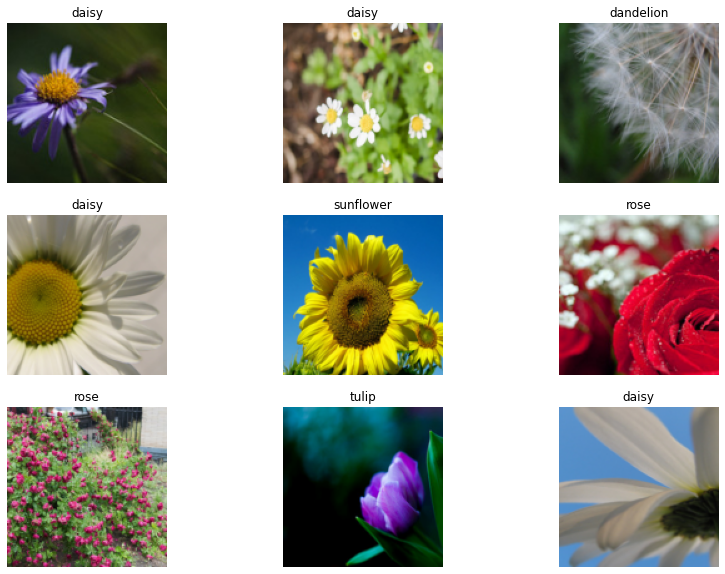

In [22]:
data.show_batch(figsize=(14,10))

## Printing the labels for the classes of flowers

In [23]:
print("Number of classes", data.c)

Number of classes 5


In [24]:
[print("Label #{} -> {}\n".format(i,v)) for i,v in enumerate(data.train.vocab)]

Label #0 -> daisy

Label #1 -> dandelion

Label #2 -> rose

Label #3 -> sunflower

Label #4 -> tulip



[None, None, None, None, None]

### Creating a recognition model

In [25]:
model = cnn_learner(data, resnet34, metrics=accuracy,  model_dir="/tmp/model2/")

## Finding the most optimal learning rate

SuggestedLRs(valley=0.0003311311302240938)

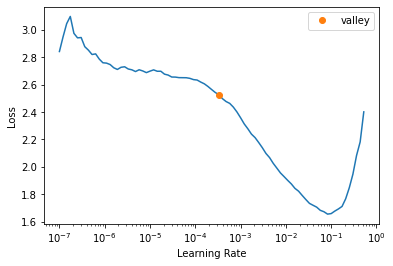

In [26]:
model.lr_find()

## Training a model

In [27]:
model.fit_one_cycle(2, 12e-3)

## Saving the model in a file

In [28]:
model.save('./my_model.pkl')

Path('/tmp/model2/my_model.pkl.pth')

In [29]:
model.export("model")

In [30]:
!ls /tmp/model2/

my_model.pkl.pth


In [31]:
!ls

 flowers		  'kaggle (1).json'   sample_data
 flowers-recognition.zip   kaggle.json


## Loading Model from file

In [32]:
filename='/tmp/model2/my_model.pkl.pth'
model2 = load_learner("/tmp/model2/my_model.pkl.pth", cpu=False)

In [33]:
m = model2['model']

## Showing a sample result

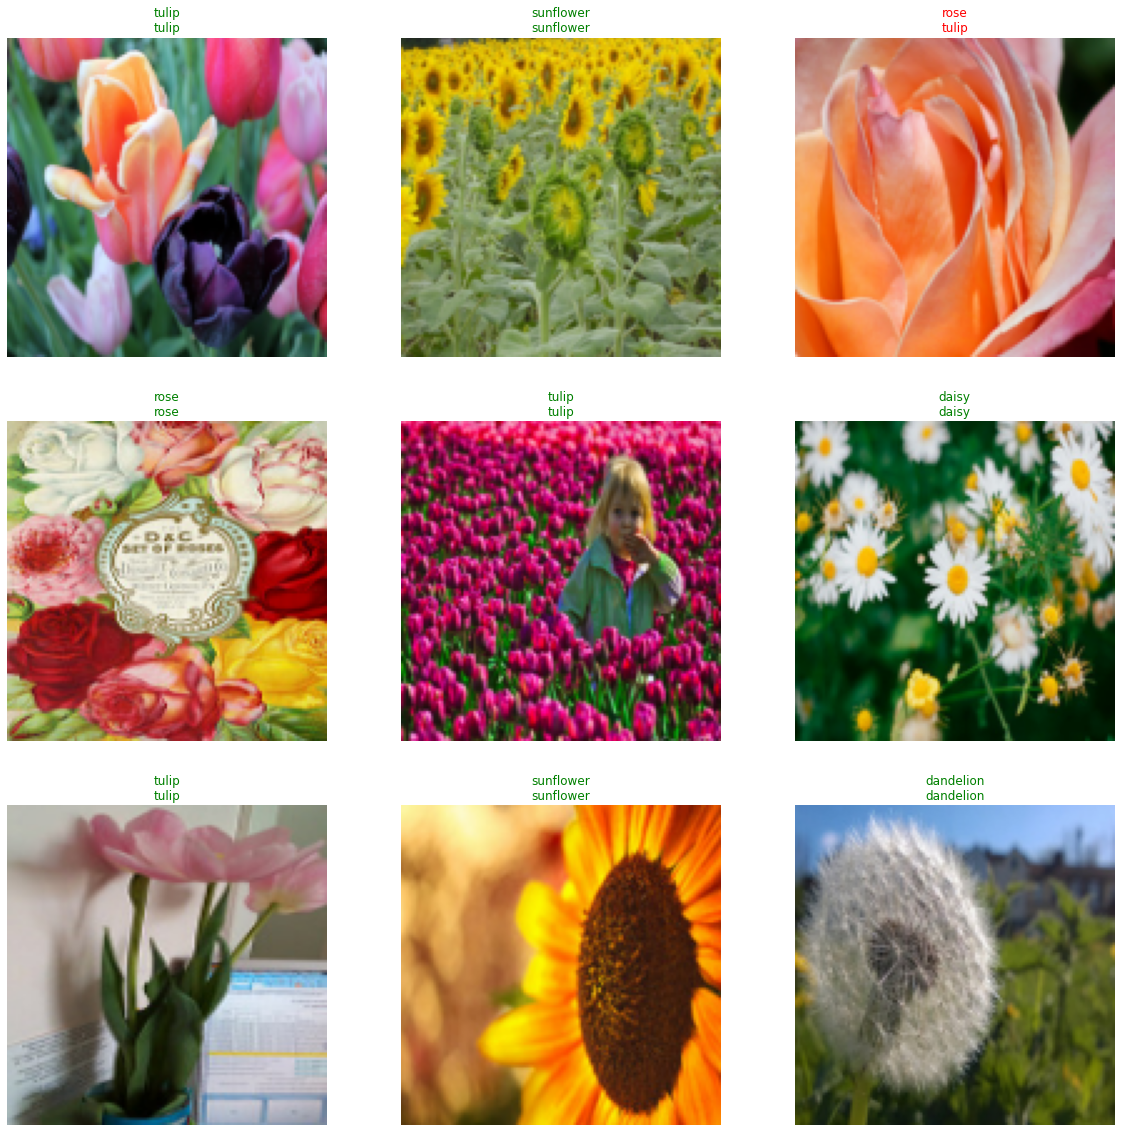

In [34]:
model.show_results(figsize=(20,20))

## Interpret the model results

In [35]:
def plot_top_losses_debug(interp,idx, k=9, largest=True, **kwargs):
    if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
    if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
    else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
    k=9
    b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
    x,y,its = interp.dl._pre_show_batch(b, max_n=k)
    b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
    x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
    if its is not None:
        plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses, figsize=(20,20))

In [36]:
interpretation = ClassificationInterpretation.from_learner(model)
losses, idx = interpretation.top_losses()

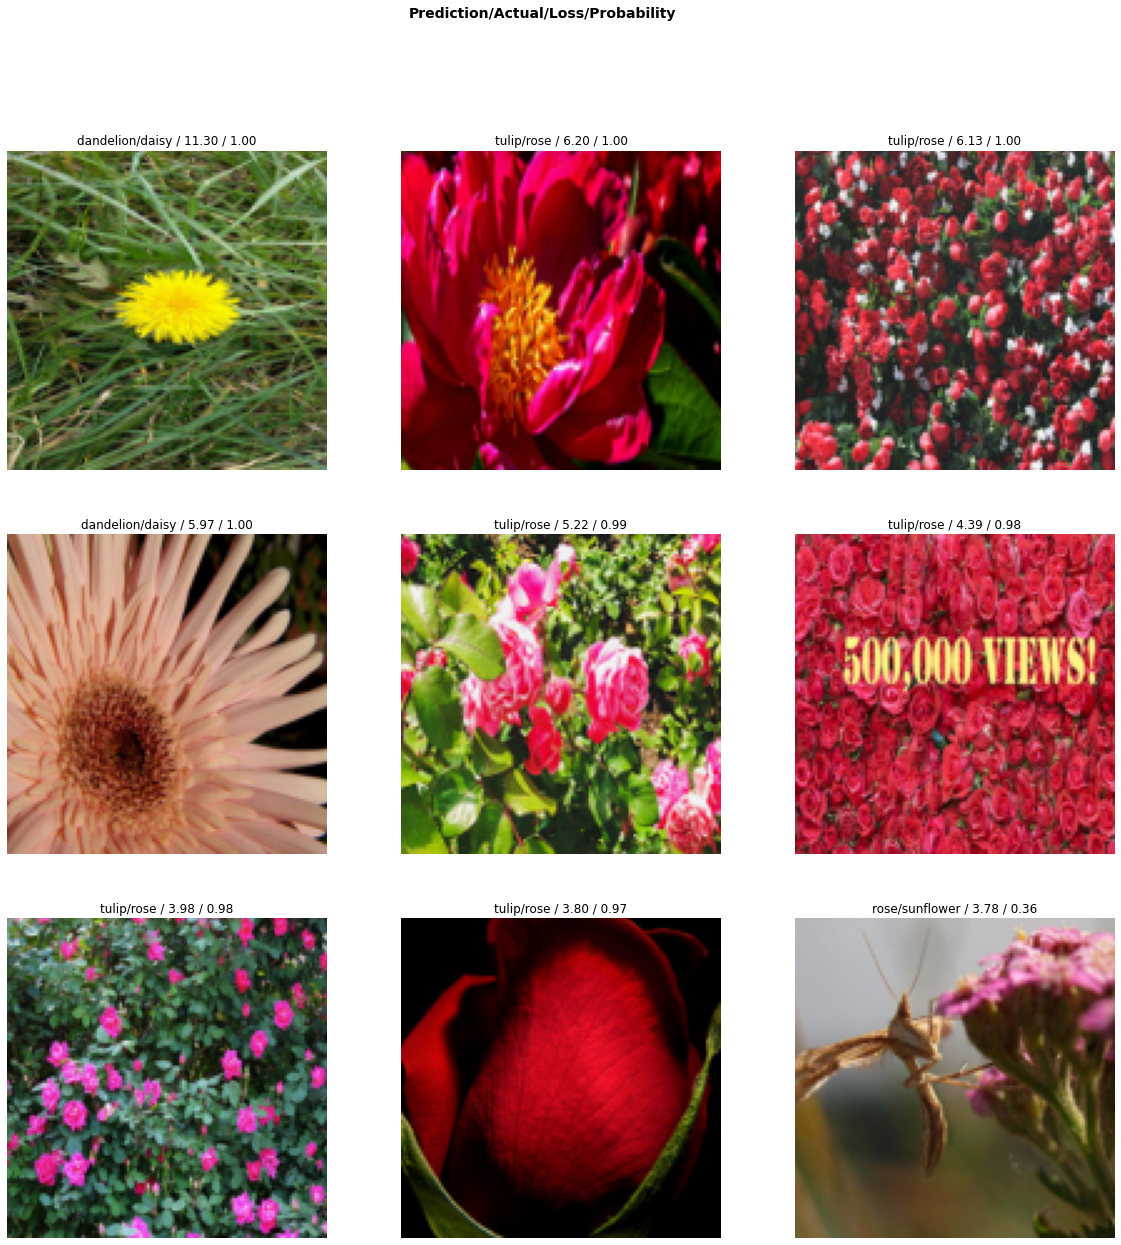

In [37]:
plot_top_losses_debug(interpretation,idx, k=9, largest=True,  figsize=(10,20))

## Confusion Matrix

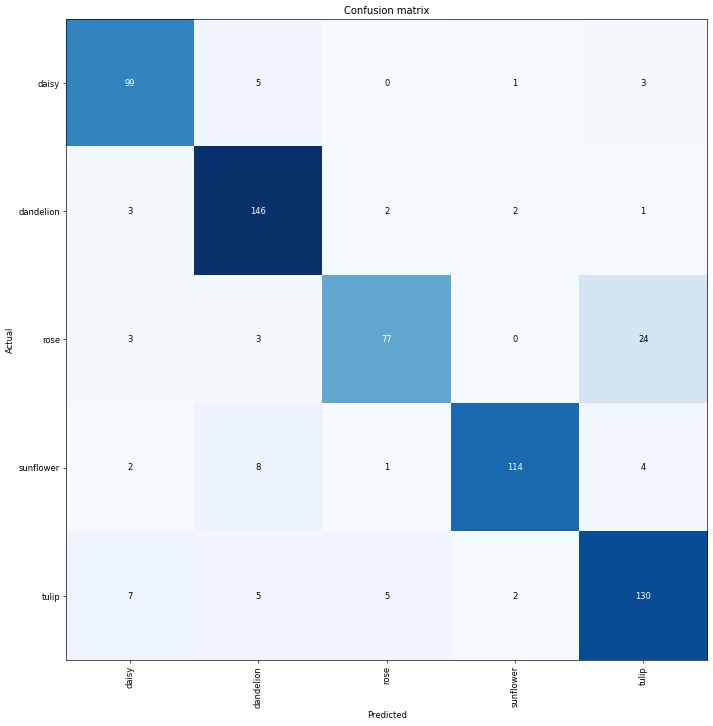

In [38]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Plot top losses

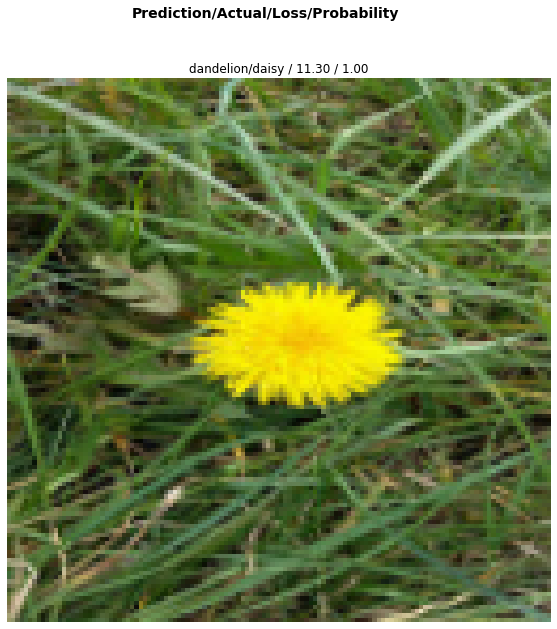

In [42]:
interpretation.plot_top_losses(1, figsize=(15,10))

In [43]:
interpretation.most_confused(min_val=2)

[('rose', 'tulip', 24),
 ('sunflower', 'dandelion', 8),
 ('tulip', 'daisy', 7),
 ('daisy', 'dandelion', 5),
 ('tulip', 'dandelion', 5),
 ('tulip', 'rose', 5),
 ('sunflower', 'tulip', 4),
 ('daisy', 'tulip', 3),
 ('dandelion', 'daisy', 3),
 ('rose', 'daisy', 3),
 ('rose', 'dandelion', 3),
 ('dandelion', 'rose', 2),
 ('dandelion', 'sunflower', 2),
 ('sunflower', 'daisy', 2),
 ('tulip', 'sunflower', 2)]